<a href="https://colab.research.google.com/github/Mani7795/BigData/blob/main/2024S1_COMP8221_Assignment1_47834781_Maniratnam_Meka_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow based Models


    Maniratnam Meka
    47834781

# Implementing NICE Flow Based Model

Before Executing a directory needs to be created in the current directory named ("**saved_models**")

## Implementation

Here Non-linear independent component estimation flow based model is being implemented. The main idea and architecture is taken from the paper, NICE: Non-linear Independent Components Estimation(https://arxiv.org/abs/1410.8516)

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution, Uniform
import torch.optim as optim
from torchvision import transforms, datasets
import numpy as np

## Design

### Variable change for density estimation
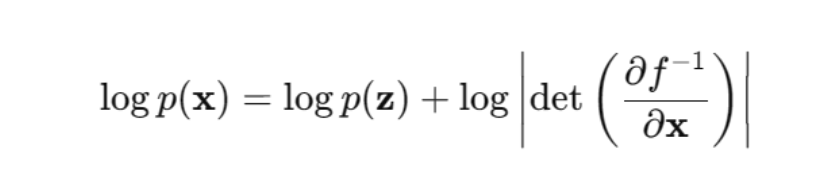
Here is the formula for the variable change for density estimation. From the below code you can see that classes ScalingLayer, CouplingLayer consists the variable change function. Both the classes have forward function which are interelated. The forward function in coupling layer, the transformation is applied only to one variable and other variable is left unchanged. On the other hand the in scaling layer the the log_scale_vector is exponentiated as it should be positive. This vector is multipled with the input and jacobian log det is added to log det. The log determinent of jacobian is calculated as data passed through each layer.
Logistic Distibution gives the log pdf of the sample

In [2]:
gpu = {
  'MODEL_SAVE_PATH': './saved_models/',
  'USE_CUDA': True,
}
class CouplingLayer(nn.Module):
  def __init__(self, data_dim, hidden_dim, mask, num_layers=4):
    super().__init__()
    assert data_dim % 2 == 0
    self.mask = mask
    modules = [nn.Linear(data_dim, hidden_dim), nn.LeakyReLU(0.25)]
    for i in range(num_layers - 2):
      modules.append(nn.Linear(hidden_dim, hidden_dim))
      modules.append(nn.LeakyReLU(0.25))
    modules.append(nn.Linear(hidden_dim, data_dim))

    self.m = nn.Sequential(*modules)

  def forward(self, x, logdet, invert=False):
        x1, x2 = self.mask * x, (1. - self.mask) * x
        m_x1 = self.m(x1) * (1. - self.mask)
        if invert:
            return x1 + (x2 - m_x1), logdet
        return x1 + m_x1, logdet


class ScalingLayer(nn.Module):
  def __init__(self, data_dim):
    super().__init__()
    self.log_scale_vector = nn.Parameter(torch.randn(1, data_dim, requires_grad=True))

  def forward(self, x, logdet, invert=False):
        log_det_jacobian = torch.sum(self.log_scale_vector)
        scale = torch.exp(self.log_scale_vector if not invert else -self.log_scale_vector)
        return x * scale, logdet + (log_det_jacobian if not invert else -log_det_jacobian)

class LogisticDistribution(Distribution):

  def log_prob(self, x):
    return -(F.softplus(x) + F.softplus(-x))

  def sample(self, size):
    if gpu['USE_CUDA']:
      z = Uniform(torch.cuda.FloatTensor([0.]), torch.cuda.FloatTensor([1.])).sample(size)
    else:
      z = Uniform(torch.FloatTensor([0.]), torch.FloatTensor([1.])).sample(size)
    return torch.log(z) - torch.log(1. - z)

### Model Implementation using Pytorch

The model consists of multiple layers from coupling layer and scaling layer. The forwad function is used to find the log likelihood of the data if it is invert the it will give inverse log likelihood of the transformed data. Inverse transformation is used to regenerate the images from the trained model, the f_inverse function applies the inverse transfomration using the scaling layers and coupling layers which generate the distribution of the samples

In [3]:
class NICE(nn.Module):
  def __init__(self, data_dim, num_coupling_layers=4):
    super().__init__()
    self.data_dim = data_dim
    self.coupling_layers = nn.ModuleList([CouplingLayer(data_dim=data_dim, hidden_dim= 256, mask=self._get_mask(data_dim, orientation=(i % 2 == 0)), num_layers=6)
                              for i in range(num_coupling_layers)])
    self.scaling_layer = ScalingLayer(data_dim=data_dim)
    self.prior = LogisticDistribution()

  def forward(self, x, invert=False):
    if not invert:
      z, log_det_jacobian = self.f(x)
      log_likelihood = torch.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
      return z, log_likelihood
    return self.f_inverse(x)

  def f(self, x):
    z = x
    log_det_jacobian = 0
    for coupling_layer in self.coupling_layers:
      z, log_det_jacobian = coupling_layer(z, log_det_jacobian)
    z, log_det_jacobian = self.scaling_layer(z, log_det_jacobian)
    return z, log_det_jacobian

  def f_inverse(self, z):
    x = z
    x, _ = self.scaling_layer(x, 0, invert=True)
    for coupling_layer in reversed(self.coupling_layers):
      x, _ = coupling_layer(x, 0, invert=True)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.data_dim])
    return self.f_inverse(z)

  def _get_mask(self, dim, orientation=True):
    mask = np.zeros(dim)
    mask[::2] = 1.
    if orientation:
      mask = 1. - mask
    mask = torch.tensor(mask)
    if gpu['USE_CUDA']:
      mask = mask.cuda()
    return mask.float()

## Dataset and Preprocessing

The model is trained to MNIST dataset as generative models take lot of computional power, the mnist dataset size is smaller and the image resolution is less as compared to CIFAR-10 or ImageNet. Imagenet is unsupervised where most of the images are not labelled. The dataset is divided into training and test dataset. The pixel values are normalized in the range of [-1,1] and randomly rotating the images by 10 degrees. But doing normalization deprecated the results.


In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.RandomRotation(degrees=10),
    transforms.Normalize((0.5,), (0.5,))
    ])
mnist_train = datasets.MNIST(root='./data/mnist', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data/mnist', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size= 128, shuffle=True, pin_memory=False)
dataloader_test = torch.utils.data.DataLoader(dataset=mnist_test, batch_size= 128, shuffle=True, pin_memory=False)




## Training the model

The model is trained for 50 epoches,adam optimizer is used, learning rate is set to default which is 0.001. 2 parameters are passed to nice model, data_dim which is the input channels of the image(28*28) where 28 is height and width of the image. The number of coupling layers is 4. Log- likelihood is taken as the evaluation metrics while training the model. The object here is lower the negative log-likelihood. We are archineving that by maximum likelihood function.


In [20]:
model = NICE(data_dim=784, num_coupling_layers=4)
if gpu['USE_CUDA']:
  device = torch.device('cuda')
  model = model.to(device)
model.train()
optimizer = optim.Adam(model.parameters())
for i in range(25):
  mean_likelihood = 0.0
  num_minibatches = 0
  for batch_id, (x, _) in enumerate(dataloader):
      x = x.view(-1, 784) + torch.rand(784) / 256.
      if gpu['USE_CUDA']:
        x = x.cuda()
      x = torch.clamp(x, 0, 1)
      z, likelihood = model(x)
      loss = -torch.mean(likelihood)
      loss.backward()
      optimizer.step()
      model.zero_grad()

      mean_likelihood -= loss
      num_minibatches += 1

  mean_likelihood /= num_minibatches
  print('Epoch {}. Log Likelihood: {}'.format(i, mean_likelihood))

  if i % 5 == 0:
    save_path = os.path.join(gpu['MODEL_SAVE_PATH'], '{}.pt'.format(i))
    torch.save(model.state_dict(), save_path)

Epoch 0. Log Likelihood: -946.7432250976562
Epoch 1. Log Likelihood: -579.0274047851562
Epoch 2. Log Likelihood: -211.32733154296875
Epoch 3. Log Likelihood: 156.36770629882812
Epoch 4. Log Likelihood: -104930.5859375
Epoch 5. Log Likelihood: 409.048095703125
Epoch 6. Log Likelihood: 435.41680908203125
Epoch 7. Log Likelihood: 443.3690185546875
Epoch 8. Log Likelihood: 449.2096862792969
Epoch 9. Log Likelihood: 455.31915283203125
Epoch 10. Log Likelihood: 462.510986328125
Epoch 11. Log Likelihood: 471.2978210449219
Epoch 12. Log Likelihood: 482.1659240722656
Epoch 13. Log Likelihood: 495.6695251464844
Epoch 14. Log Likelihood: 512.4703979492188
Epoch 15. Log Likelihood: 533.3564453125
Epoch 16. Log Likelihood: 559.2460327148438
Epoch 17. Log Likelihood: 591.2018432617188
Epoch 18. Log Likelihood: 630.4056396484375
Epoch 19. Log Likelihood: 678.133056640625
Epoch 20. Log Likelihood: 735.708984375
Epoch 21. Log Likelihood: 804.470703125
Epoch 22. Log Likelihood: 885.7396240234375
Epoch 2

## Evaluation

The log likelihood value when evaluated on the test dataset was near to 1000. This value gives how accurately the images are being generated, the model paper I have taken into consideration gave an likelihood value of around 1950 after 75 epoches. The images generated for that value have less noise and the quality of the images is better than compare to the results I was able to obtain.

In [21]:
model.eval()
total_likelihood = 0.0
num_samples = 0
for batch_id, (x_test, _) in enumerate(dataloader_test):
    x_test = x_test.view(-1, 784) + torch.rand(784) / 256.
    if gpu['USE_CUDA']:
        x_test = x_test.cuda()
    x_test = torch.clamp(x_test, 0, 1)
    with torch.no_grad():
        z_test, likelihood_test = model(x_test)
    total_likelihood += torch.sum(likelihood_test).item()
    num_samples += x_test.size(0)
mean_likelihood_test = total_likelihood / num_samples
print('Evaluation completed. Log Likelihood on Test Dataset: {}'.format(mean_likelihood_test))


Evaluation completed. Log Likelihood on Test Dataset: 1150.594657421875


## Analysis and Visualisation

The images are generated based on the evaluated model, the models are blury, for improvement we can increase the number of epoches but the computation time is more for executing the model.

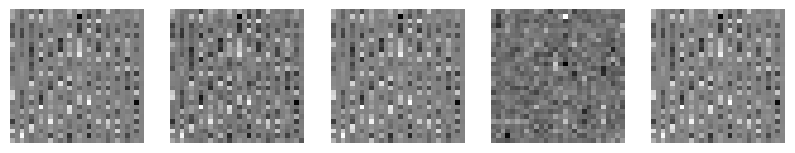

In [22]:
import matplotlib.pyplot as plt

def generate_and_analyse_images(model, num_sam):
    model.eval()
    distribution = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
    noise = distribution.sample((num_sam, model.data_dim)).squeeze()
    noise = noise.to(next(model.parameters()).device)
    with torch.no_grad():
        generated = model.f_inverse(noise)
    generated = generated.view(-1, 1, 28, 28)
    plt.figure(figsize=(10, 2))
    for i in range(num_sam):
        plt.subplot(1, num_sam, i+1)
        plt.imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()
generate_and_analyse_images(model, 5)


### Visualising the learned representation

The plot form a distinct pattern and seperatation between points, the reason can be that the model is able to properly discriminate the different labels and classes in the data. Here each clusters represent the different categories. Here we are randomly considering 500 samples, where PCA (Principal component analysis) is used to reduce the dimensionality of the samples and fit it to the model.

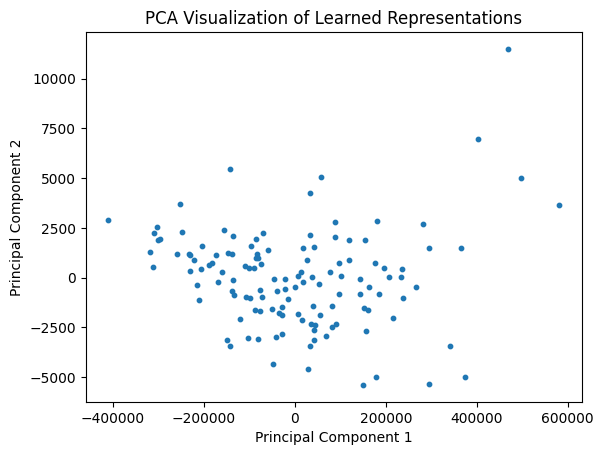

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

num_samples = 500
data_samples = next(iter(dataloader))[0][:num_samples]
if gpu['USE_CUDA']:
    data_samples = data_samples.cuda()

# Reshape the data samples to 1D vectors
data_samples = data_samples.view(data_samples.size(0), -1)

# Get the representations from the trained model
with torch.no_grad():
    representations, _ = model.f(data_samples)
pca = PCA(n_components=2)
reduced_representations = pca.fit_transform(representations.cpu().numpy())
plt.scatter(reduced_representations[:, 0], reduced_representations[:, 1], s=10)
plt.title('PCA Visualization of Learned Representations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Model Enhancement

Tried to implement the Multi-scale architecture. The model has multiple scales where the 4 coupling layers are added to architecture and 3 scaling layers are added. During training the model has a mismatch with input values and index is out of range for the input sample. This might enhance the results but the execuation time will increase as this will have more parameters for calculation and will required more memory to store the features.

In [24]:
import torch.nn.functional as F

class MultiScaleNICE(nn.Module):
    def __init__(self, data_dim, num_coupling_layers=4, num_scales=3):
        self.num_scales = num_scales
        self.coupling_layers = nn.ModuleList([
            nn.ModuleList([
                CouplingLayer(data_dim=data_dim // (2**scale), hidden_dim=256, mask=self._get_mask(data_dim // (2**scale), orientation=(i % 2 == 0)), num_layers=6)
                for i in range(num_coupling_layers)
            ])
            for scale in range(num_scales)
        ])
        self.scaling_layers = nn.ModuleList([
            ScalingLayer(data_dim=data_dim // (2**scale))
            for scale in range(num_scales)
        ])
        self.prior = LogisticDistribution()

    def forward(self, x, invert=False):
        if not invert:
            z, log_likelihood = self.f(x)
            return z, log_likelihood
        return self.f_inverse(x)

    def f(self, x):
        z_list = []
        log_likelihood = 0
        for scale in range(self.num_scales):
            z = x if scale == 0 else F.avg_pool2d(x, kernel_size=2, stride=2)  # Downsample if not at the finest scale
            log_det_jacobian = 0
            for coupling_layer in self.coupling_layers[scale]:
                z, log_det_jacobian = coupling_layer(z, log_det_jacobian)
            z, log_det_jacobian = self.scaling_layers[scale](z, log_det_jacobian)
            z_list.append(z)
            log_likelihood += log_det_jacobian
        return torch.cat(z_list, dim=1), log_likelihood

    def f_inverse(self, z):
        x_list = []
        z_splits = torch.split(z, [self.data_dim // (2**scale) for scale in range(self.num_scales)], dim=1)
        for scale, z_scale in enumerate(z_splits):
            x = z_scale
            for coupling_layer in reversed(self.coupling_layers[scale]):
                x, _ = coupling_layer(x, 0, invert=True)
            x, _ = self.scaling_layers[scale](x, 0, invert=True)
            x_list.append(x)
            if scale < self.num_scales - 1:
                x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample if not at the finest scale
        return torch.cat(x_list, dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, self.data_dim])
        return self.f_inverse(z)

    def _get_mask(self, dim, orientation=True):
        mask = np.zeros(dim)
        mask[::2] = 1.
        if orientation:
            mask = 1. - mask
        mask = torch.tensor(mask)
        if gpu['USE_CUDA']:
            mask = mask.cuda()
        return mask.float()




# Conclusion

  1. Finally, the flow based models have the ability to regenerate the images from the past images using inverse transformation. The NICE model features efficient unbiased ancestral sampling and achieves competitive results in terms of log-likelihood[1].
  2. The model is trained on MNIST dataset which consist of images of digits with low resolution. When the augumentation on digits was done like changing the angle of images by 10 degrees only deprecated the results as the images are of digits, changing the angle makes results worse.
  3. The model is trained and the metrics used to evaluate the model is log-likelihood function, where the current model achieved around 1000 after 25 epoches. There is a room for improvement.
  4. The images generated by the model has noise in it, the better value of likelihood can produce the images with less noise and more readable. whereas for the dimensionality reduction we can see the patterns in the data which means that the data is able to differentiate the categories.

# Reference

1. Dinh, L., Krueger, D., & Bengio, Y. (2014). NICE: Non-linear Independent Components Estimation. ArXiv. /abs/1410.8516
2. Qian, X., Fu, Y., Jiang, Y.-G., Xiang, T., & Xue, X. (2022). Multi-scale Deep Learning Architectures for Person Re-identification. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(1), 123-135